AUGUSTE Charles & DELORO Yonatan

# Machine Learning et applications
# TP4 - Perceptron, SVMs

Pour le 21 mai 2017

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
from tools import *

#plt.rcParams['figure.figsize'][0] = 12

# 1. Implémentation du perceptron

Question 1.1

Le modèle du perceptron est équivalent à l'optimisation d'un classifieur linéaire dont la fonction de coût est (en moyennant les couts sur les données) :

$$L(W,X,Y)=\frac{1}{n} \sum_k \max{(0,-Y^kX^kW^T)}$$

en rebaptisant X la matrice de design $
X=\begin{pmatrix}
       1 & x^0_1 & ... & x^0_d \\
       1 & x^1_1 & ... & x^1_d \\
       \vdots & \vdots & \ddots & \vdots \\
       1 & x^n_1 & ... & x^n_d \\
\end{pmatrix}$
, et notant les labels $
Y= 
\left( \begin{array}{c}
Y^0 \\
Y^1 \\
\vdots \\
Y^n
\end{array} \right)$ et le vecteur des poids $
W=
\left( \begin{array}{c}
W_0 ~ W_1 ~ ... ~ W_d
\end{array} \right)
$

Avec $f_W(X)=XW^T$ et $g_Y(V)=\frac{1}{n} \sum_k \max{(0,-Y^kV^k)}$, on peut écrire : $L(W,X,Y)=g_Y(f_W(X))$.

En appliquant la règle de la chaîne, on a:

$$\frac{\partial L}{\partial W_i}(W,X,Y)=\sum_k \frac{\partial f_W(X)_k}{\partial W_i}(X)\frac{\partial g_Y(V)}{\partial V_k}(f_W(X))=\frac{1}{n} \sum_k X^k_i(V \rightarrow -{1}_{sgn(Y^kV^k) \leq 0}Y^k).(f_W(X)) = - \frac{1}{n} \sum_k {1}_{sgn(Y^kX^kW^T) \leq 0}Y^kX^k_i $$

Soit : $$\nabla_W L(W,X,Y) = - \frac{1}{n} \sum_k {1}_{sgn(Y^kX^kW^T) \leq 0}Y^k{X^k}^T $$

In [3]:
def hinge(w,data,y):
    #Retourne le coût hinge pour le vecteur de paramètres w,
    #la matrice d'exemples data, et le vecteur de labels
    data=data.reshape(len(y),-1)
    y=y.reshape(-1,1)
    w=w.reshape(1,-1)
    return np.mean(np.maximum(0,-y*np.dot(data,w.T)))

def grad_hinge(w,data,y):
    #Retourne le gradient du coût hinge pour le vecteur de paramètres w,
    #la matrice d'exemples data, et le vecteur de labels y
    data=data.reshape(len(y),-1)
    y=y.reshape(-1,1)
    w=w.reshape(1,-1)
    gradient = (y * np.dot(data,w.T) < 0) * (-y * data)
    return np.mean(gradient.T, axis = 1)

def with_bias(data):
    #transforme la matrice de données de manière à prendre en compte le biais
    (n,d)=np.shape(data)
    col_id=np.reshape((np.ones(n)),(n,1)) #vecteur colonne de 1
    return np.concatenate((col_id,data),axis=1)  #matrice de design


class Perceptron:
    def __init__(self,max_iter = 100,eps=1e-3,projection = None,params_gaussians = None,lbd = 0):
        self.max_iter = max_iter
        self.eps = eps
        self.projection = projection or (lambda x: x) #projection fonction identite par default
        self.params_gaussians = params_gaussians or None
        #si la projection est un plongement gaussien, params_gaussians=(nombre de gaussiennes,way)
        #où way(="alea" ou "train") est la manière de choisir les centres des gaussiennes
        self.lbd=lbd #constante de régularisation pour la fonction de perte

    def fit(self,data,y):
        if self.params_gaussians==None: #si la projection n'est pas un plongement gaussien
            data = self.projection(data)
        else: #si la projection est un plongement gaussien
            self.centers_gaussians=choose_centers_gaussians(self.params_gaussians[0],self.params_gaussians[1],data)
            data = self.projection(data,self.centers_gaussians)
        self.w = np.random.random((1,data.shape[1]))
        self.histo_w  = np.zeros((self.max_iter,data.shape[1]))
        self.histo_f = np.zeros((self.max_iter,1))
        ylab=set(y.flat)
        if len(ylab)!=2:
            print("pas bon nombres de labels (%d)" % (ylab,))
            return
        self.labels = {-1: min(ylab), 1:max(ylab)}
        y = 2*(y!=self.labels[-1])-1
        i=0
        while i<self.max_iter:
            idx = range(len(data))
            for j in idx:
                self.w = self.w - self.get_eps()*self.loss_g(data[j],y[j:(j+1)])
            self.histo_w[i]=self.w
            self.histo_f[i]=self.loss(data,y)
            #if i % 10==0: print(i,self.histo_f[i])
            i+=1
    def predict(self,data):
        if self.params_gaussians==None: #si la projection n'est pas un plongement gaussien
            data = self.projection(data)
        else: #si la projection est un plongement gaussien
            data = self.projection(data,self.centers_gaussians)
        return np.array([self.labels[x] for x in np.sign(data.dot(self.w.T)).flat]).reshape((len(data),))
    def score(self,data,y):
        return np.mean(self.predict(data)==y)
    def get_eps(self):
        return self.eps
    def loss(self,data,y):
        return hinge(self.w,data,y)+self.lbd*pow(np.linalg.norm(self.w),2)
    def loss_g(self,data,y):
        return grad_hinge(self.w,data,y)+2*self.lbd*self.w
    def histo_loss_predicts(self,data,y):
        #Retourne un vecteur stockant la perte hinge sur les prédictions de data
        #obtenue pour chaque w appris
        histo_loss = np.zeros((self.max_iter,1))
        data=self.projection(data)
        ylab=set(y.flat)
        if len(ylab)!=2:
            print("pas bon nombres de labels (%d)" % (ylab,))
            return
        self.labels = {-1: min(ylab), 1:max(ylab)}
        y = 2*(y!=self.labels[-1])-1
        for i in range(self.max_iter):
            histo_loss[i]=hinge(self.histo_w[i],data,y)
        return histo_loss

In [4]:
def question_11():
    ### Test des fonctions hinge, grad_hinge
    w = np.random.random((3,))
    data = np.random.random((100,3))
    y = np.random.randint(0,2,size = (100,1))*2-1
    print(hinge(w,data,y), hinge(w,data[0],y[0]), hinge(w,data[0,:],y[0]))
    print(grad_hinge(w,data,y),grad_hinge(w,data[0],y[0]).shape,grad_hinge(w,data[0,:],y[0]).shape)
    
question_11()

0.306289766966 0.137607349164 0.137607349164
[ 0.20333749  0.21619003  0.26423896] (3,) (3,)


In [5]:
def learn_and_predict_with_Perceptron(xtrain,ytrain,xtest,ytest,proj=None,params_gauss=None,visualize=False,lbd=0,max_iter = 100,e=1e-3):
    #create a perceptron, predict the label of xtest and measure the score
    #return perceptron P
    #if "visualize==True", print the curbs of train and test errors at each
    #step of the fitting

    #params_gauss utile pour la question 3.4 :
    #si la projection est un plongement gaussien, params_gaussians correspond
    #au nombres de gaussiennes et à la manière de choisir leurs centres

    P=Perceptron(eps=e,max_iter = max_iter,projection=proj,params_gaussians=params_gauss,lbd=lbd)
    P.fit(xtrain,ytrain)
    print("score en train : ", P.score(xtrain,ytrain))
    print("score en test : ", P.score(xtest,ytest))

    if (visualize):
        plt.figure()
        plt.plot(P.histo_f.flatten(),color='b')
        histo_loss_test=P.histo_loss_predicts(xtest,ytest)
        plt.plot(histo_loss_test,color='r')
        plt.xlabel("Nombre d'itérations")
        plt.ylabel("Erreurs")
        plt.title("Erreurs d'apprentissage (bleu) et de test (rouge) \n \
        au fil des itérations du fitting")
        plt.show()

    return P

score en train :  1.0
score en test :  1.0


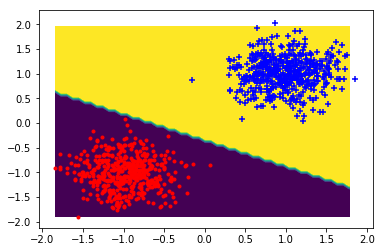

In [6]:
def question_12():
    ### Generation de donnees
    xtrain,ytrain = gen_arti(data_type=0,epsilon=0.01)
    xtest,ytest = gen_arti(data_type=0,epsilon=0.01)
    model=learn_and_predict_with_Perceptron(xtrain,ytrain,xtest,ytest,proj=with_bias)

    #### Tracé de frontiere
    plot_frontiere(xtest,model.predict,50)
    plot_data(xtest,ytest)
    plt.show()

question_12()

Question 1.2

On teste le perceptron sur le jeu de données à 2 gaussiennes (bruitées à 0.01), en considérant un pas de gradient fixe $\epsilon=0.001$ pour l'apprentissage que l'on considère achevé au bout de 100 itérations. Conformément à l'intuition, on observe, par le score et visuellement, que le perceptron arrive à bien classifier les deux types de données décrites par leurs 2 coordonnées.

Cas faiblement bruitée (eps=0.001), séparable
score en train :  1.0
score en test :  0.998


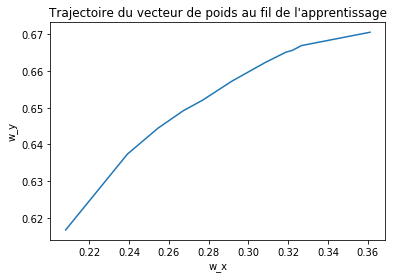

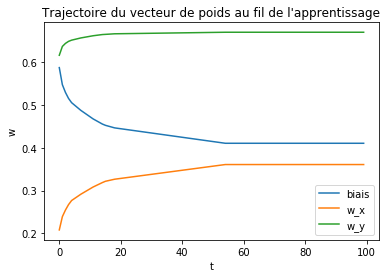

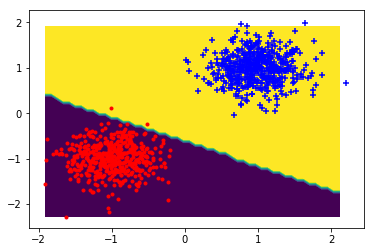

Cas fortement bruitée (eps=1), non séparable
score en train :  0.891
score en test :  0.913


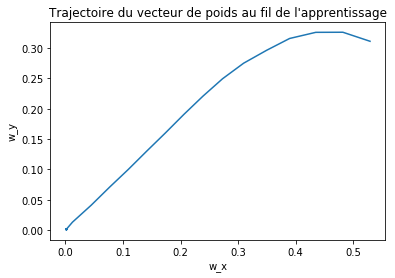

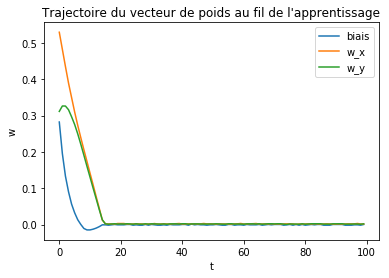

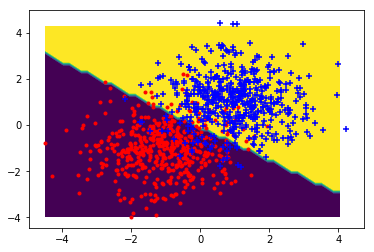

In [7]:
def question_13(e):
    #Sur données artificielles (e bruit des données)
    ### Generation de donnees
    xtrain,ytrain = gen_arti(data_type=0,epsilon=e)
    xtest,ytest = gen_arti(data_type=0,epsilon=e)

    model=learn_and_predict_with_Perceptron(xtrain,ytrain,xtest,ytest,proj=with_bias)

    #Trajectoire de l'apprentissage dans l'espace des poids
    plt.figure()
    plt.plot(model.histo_w[:,1],model.histo_w[:,2])
    #Q=plt.quiver(model.histo_w[:-1,1],model.histo_w[:-1,2],model.histo_w[1:,1]-model.histo_w[:-1,1],model.histo_w[1:,2]-model.histo_w[:-1,2],headwidth=0.0000001)
    plt.title("Trajectoire du vecteur de poids au fil de l'apprentissage")
    plt.xlabel("w_x")
    plt.ylabel("w_y")
    plt.show()
    
    plt.figure()
    plt.plot([t for t in range(len(model.histo_w[:,0]))], model.histo_w[:,0], label = "biais")
    plt.plot([t for t in range(len(model.histo_w[:,1]))], model.histo_w[:,1], label = "w_x")
    plt.plot([t for t in range(len(model.histo_w[:,1]))], model.histo_w[:,2], label = "w_y")
    plt.title("Trajectoire du vecteur de poids au fil de l'apprentissage")
    plt.xlabel("t")
    plt.ylabel("w")
    plt.legend()
    plt.show()

    #### Tracé de frontiere
    plt.figure()
    plot_frontiere(xtest,model.predict,50)
    plot_data(xtest,ytest)
    plt.show()

print("Cas faiblement bruitée (eps=0.001), séparable")
question_13(0.001) #eps
print("Cas fortement bruitée (eps=1), non séparable")
question_13(1.) #eps

Question 1.3

On affiche les prédictions du perceptron, réglé aux mêmes paramètres que dans la question précédente, pour le jeu à 2 gaussiennes, et des bruits respectifs de 0.001 (cas séparable) et de 1. (cas non séparable). On trace également la trajectoire du vecteur de poids au fil de l'apprentissage.

Dans le cas séparable, la plupart du temps, on tombe directement sur des valeursqui permettent de discriminer optimalement les données de test. Si ce n'est pas le cas, on converge très vite. Dans le cas non séparable, tous les coefficients tendent vers des valeurs proches de 0 au bout de quelques dizaines d'itérations. C'est parce que l'on essaie de minimiser la perte hinge-loss. Lorsque les coefficients diminuent, on arrive toujours à discriminer les points faciles à discriminer (ceux qui se situent bien dans leur zone), mais l'erreur sur les points durs à discriminer diminue.

- Dans le cas séparable (bruit de 0.001), la frontière de décision n'est évidemment pas unique. Celle qui est obtenue est satisfaisante mais ne semble peut-être pas optimale : on aimerait l'ajuster un peu pour diminuer les distances aux points bleus qui semblent plus éloignés que les rouges, ou l'inverse suivant les cas. Pour obtenir une meilleure frontière, on pourrait utiliser la technique de Hard Margin vue en cours, visant à maximiser la marge, ou la distance entre les deux droites parallèles à la frontière de décision et passant respectivement par les points bleus et rouges les plus proches (ou encore à pénaliser les points bleux et rouges les plus éloignées).


- Dans le cas non séparable (bruit de 1.), la frontière de décision semble plutôt satisfaisante, passant bien au milieu de la zone de conflit où se chevauchent les deux nuages de point. On pourrait utiliser la technique de Soft margin pour être sur d'avoir la meilleure droite.


# 2. Données USPS

Un chiffre contre un autre : 6 contre 9
score en train :  1.0
score en test :  0.988472622478


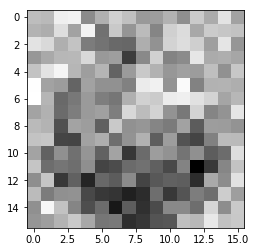

Deux chiffres contre deux autres : 1,2 contre 6,8
score en train :  0.979265805574
score en test :  0.931077694236


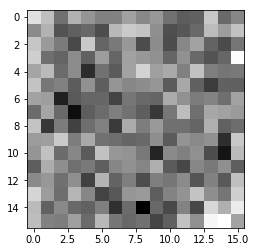

In [8]:
def load_usps(filename):
    with open(filename,"r") as f:
        f.readline()
        data =[ [float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp = np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)

def get_usps(l,datax,datay):
    """ l : liste des chiffres a extraire"""
    if type(l)!=list:
        resx = datax[datay==l,:]
        resy = datay[datay==l]
        return resx,resy
    tmp =   list(zip(*[get_usps(i,datax,datay) for i in l]))
    tmpx,tmpy = np.vstack(tmp[0]),np.hstack(tmp[1])
    idx = np.random.permutation(range(len(tmpy)))
    return tmpx[idx,:],tmpy[idx]

def show_usps(data):
    plt.imshow(data.reshape((16,16)),interpolation="nearest",cmap="gray")

def question_21():
    #Sur données USPS
    xuspstrain,yuspstrain = load_usps("USPS_train.txt")
    xuspstest,yuspstest = load_usps("USPS_test.txt")

    print("Un chiffre contre un autre : 6 contre 9")
    x69train,y69train = get_usps([6,9],xuspstrain,yuspstrain)
    x69test,y69test = get_usps([6,9],xuspstest,yuspstest)
    P=learn_and_predict_with_Perceptron(x69train,y69train,x69test,y69test,proj=with_bias)
    show_usps(np.reshape(P.w[:,1:],(16,16)))
    plt.show()

    print("Deux chiffres contre deux autres : 1,2 contre 6,8")
    x1268train,y1268train = get_usps([1,2,6,8],xuspstrain,yuspstrain)
    x1268test,y1268test = get_usps([1,2,6,8],xuspstest,yuspstest)
    separate_12_from_68=lambda x: (x==1)or(x==2)
    separate_12_from_68=np.vectorize(separate_12_from_68)
    y1268train=separate_12_from_68(y1268train)
    y1268test=separate_12_from_68(y1268test)
    P=learn_and_predict_with_Perceptron(x1268train,y1268train,x1268test,y1268test,proj=with_bias)
    show_usps(np.reshape(P.w[:,1:],(16,16)))
    plt.show()

question_21()

Question 2.1

En conservant le même perceptron, on observe des scores très satisfaisants en apprentissage et en test dans la classification de 6 contre 9, de {1,2} contre {6,8}. 

La valeur d'une cellule de la matrice de w peut s'interpréter comme une présomption pour le label "-1" si la case est noircie. Par conséquent, dans l'exemple du classifieur du chiffre 6 ("-1") contre le chiffre 9 ("+1"), si un pixel appartient à la forme d'un chiffre à prédire et si la case de ce pixel apparait en blanc dans l'image de w (forte probabilité du label "+1"), alors ce pixel apporte une présomption pour que ce chiffre soit un "9". Si en revanche, la case apparait en noir (faible probabilité du label "+1"), ce pixel apporte une présomption pour que ce chiffre soit un "6". En blanc apparaissent donc les pixels propres au chiffre 9 et en noir les pixels caractéristiques du 6.

L'interprétation visuelle est plus difficile à faire dans le cas de {1,2} contre {6,8},puisqu'il faut ici voir les pixels blancs comme caractéristiques de la somme de "6" et "8" par opposition aux pixels noirs, caractéristiques de la somme de "1" et "2". On peut remarquer tout de même que les pixels des coins sont blancs : le 1 et le 2 sont en effet plus centraux que 6 et 8 en théorie.

Un chiffre contre un autre : 6 contre 9
score en train :  1.0
score en test :  0.994236311239


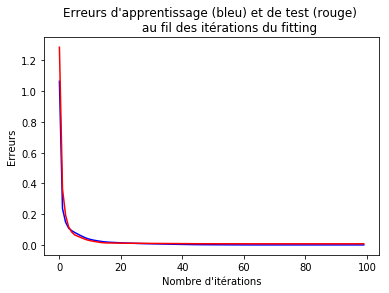

Deux chiffres contre deux autres : 1,2 contre 6,8
score en train :  0.976546566961
score en test :  0.9335839599


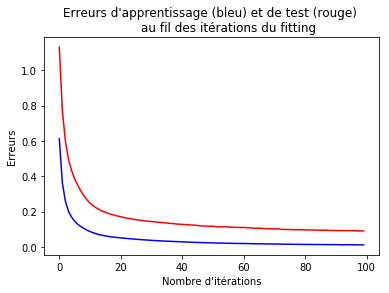

Un chiffre contre tous les autres : 6
score en train :  0.993690851735
score en test :  0.98355754858


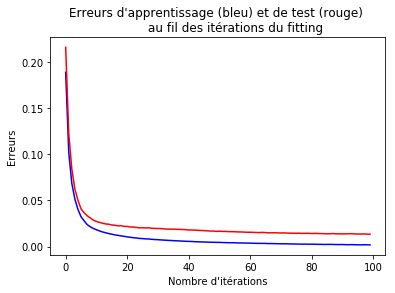

In [9]:
def question_22():
    #Sur données USPS, tracé des courbes d'erreurs en apprentissage et en est
    #au fil des itérations

    #Sur données USPS
    xuspstrain,yuspstrain = load_usps("USPS_train.txt")
    xuspstest,yuspstest = load_usps("USPS_test.txt")

    print("Un chiffre contre un autre : 6 contre 9")
    x69train,y69train = get_usps([6,9],xuspstrain,yuspstrain)
    x69test,y69test = get_usps([6,9],xuspstest,yuspstest)
    w=learn_and_predict_with_Perceptron(x69train,y69train,x69test,y69test,proj=with_bias,visualize=True)

    print("Deux chiffres contre deux autres : 1,2 contre 6,8")
    x1268train,y1268train = get_usps([1,2,6,8],xuspstrain,yuspstrain)
    x1268test,y1268test = get_usps([1,2,6,8],xuspstest,yuspstest)
    separate_12_from_68=lambda x: (x==1)or(x==2)
    separate_12_from_68=np.vectorize(separate_12_from_68)
    y1268train=separate_12_from_68(y1268train)
    y1268test=separate_12_from_68(y1268test)
    w=learn_and_predict_with_Perceptron(x1268train,y1268train,x1268test,y1268test,proj=with_bias,visualize=True)

    print("Un chiffre contre tous les autres : 6")
    all_against_6=lambda x: (x==6)
    all_against_6=np.vectorize(all_against_6)
    x6train,x6test = xuspstrain,xuspstest
    y6train = all_against_6(yuspstrain)
    y6test = all_against_6(yuspstest)
    w=learn_and_predict_with_Perceptron(x6train,y6train,x6test,y6test,proj=with_bias,visualize=True)

question_22()

Question 2.2.

On trace alors pour différents settings (6 contre 9, {1,2} contre {6,8}, et 6 contre tous) les courbes d'erreurs en apprentissage et en test en fonction du nombre d'itérations d'apprentissage du perceptron.

Dans le cas de la classification, on observe légèrement du sur-apprentissage car l'erreur de test est supérieure à l'erreur de train. On pourrait rajouter un peu de régularisaton pour l'éviter.

Deux chiffres contre deux autres : 1,2 contre 6,8
score en train :  0.975186947655
score en test :  0.93984962406


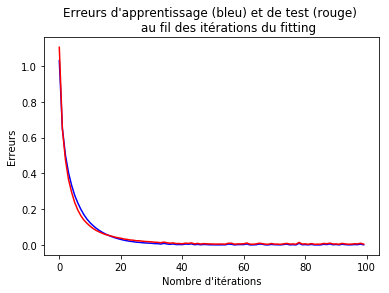

In [10]:
def question22bis():
    xuspstrain,yuspstrain = load_usps("USPS_train.txt")
    xuspstest,yuspstest = load_usps("USPS_test.txt")

    print("Deux chiffres contre deux autres : 1,2 contre 6,8")
    x1268train,y1268train = get_usps([1,2,6,8],xuspstrain,yuspstrain)
    x1268test,y1268test = get_usps([1,2,6,8],xuspstest,yuspstest)
    separate_12_from_68=lambda x: (x==1)or(x==2)
    separate_12_from_68=np.vectorize(separate_12_from_68)
    y1268train=separate_12_from_68(y1268train)
    y1268test=separate_12_from_68(y1268test)
    w=learn_and_predict_with_Perceptron(x1268train,y1268train,x1268test,y1268test,proj=with_bias,visualize=True, lbd = 0.01)

question22bis()

En rajoutant un terme de régularisation $\lambda||w||^2$, on diminue le sur-apprentissage : les courbes d'erreur sont aux mêmes niveaux.

# 3. Expressivité et feature map

score en train :  0.68
score en test :  0.693


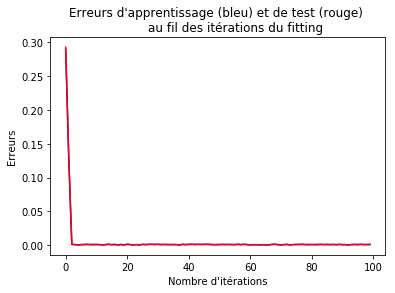

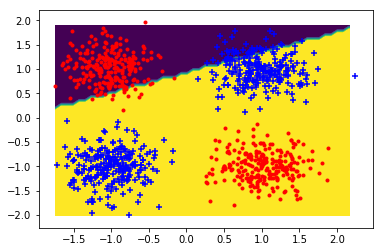

score en train :  0.529
score en test :  0.515


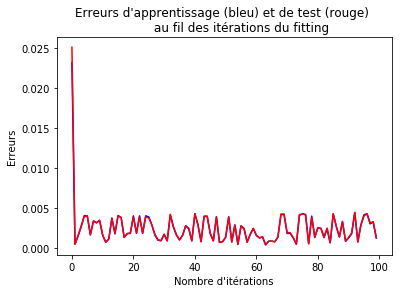

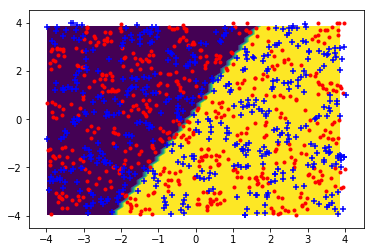

In [11]:
def question_31(jeu):
    #Test du perceptron sur les autres jeux de données artificielles
    xtrain,ytrain = gen_arti(data_type=jeu,epsilon=0.01)
    xtest,ytest = gen_arti(data_type=jeu,epsilon=0.01)
    model=learn_and_predict_with_Perceptron(xtrain,ytrain,xtest,ytest,proj=with_bias,visualize=True)

    plt.figure()
    plot_frontiere(xtest,model.predict,50)
    plot_data(xtest,ytest)
    plt.show()

question_31(1) #jeu de données artificielles
question_31(2)

Question 3.1.

On observe que le perceptron échoue à prédire les labels des jeux de données artificielles 1 et 2.
Cela n'est pas une surprise.

Considérons par exemple le premier jeu. La classe bleu est la classe +1, la classe rouge est la classe -1. Quand le perceptron reçoit une donnée d'apprentissage labellisée "bleue" de cordonnées $x$ et $y$ fortement positives, alors il augmente les poids $w_x$ et $w_y$ ; quand il en reçoit une de coordonnées $x$ et $y$ fortement négatives, alors il diminue les poids $w_x$ et $w_y$. On peut faire un raisonnement similaire sur les données rouges. Ainsi $w_x$ et $w_y$ oscillent autour de 0, et la classification est donc aléatoire.
Autrement dit, on peut dire qu'un modèle de données décrites par $x$ et $y$ n'est pas assez riche pour séparer les deux classes. Il faudrait aussi rendre compte de l'opposition de signe entre $x$ et $y$ dans les données descriptives.

On retrouve le même problème pour le deuxième jeu, de manière encore plus prononcée, puisque les points maillent de très nombreuses droites parallèles de pentes positive pour la classe bleue, négative pour la rouge, en ajoutant un bruit. La encore, le modèle n'est pas assez expressif.

Question 3.2. 

Plongement polynomial dans le cas 2D [Ce qui est attendu]

Avant de les donner en entrée au perceptron, on plonge les données dans l'espace polynomial de dimension 5 via la fonction de $\mathbb{R}^2$ dans $\mathbb{R}^5$ : $poly(x_1,x_2) = (1,x_1,x_2,x_1x_2,x_1^2,x_2^2)$.
Dans cet espace de dimension 5, la frontière de décision "tracée" par le perceptron est une droite de la forme (on a considéré le biais avec $w_0$) : $w^Tx=0 \Leftrightarrow w_0 + w_1x_1 + w_2x_2 + w_3x_1x_2 + w_4x_1^2 + w_5x_2^2 = 0$. Dans l'espace projetée (x1,x2), les frontières seront donc des coniques (paraboles/hyperboles).

Par exemple, $w=(-1,0,0,1,1)$ donnerait comme frontière dans l'espace projeté $1=x_1^2+x_2^2$ soit le cercle de centre (0,0) et de rayon 1. Une manière plus géométrique de voir ceci serait de dire que la frontière dans l'espace projeté correspond au projeté sur le plan de l'intersection d'un plan avec une paraboloide, soit à un disque.

score en train :  0.998
score en test :  0.996


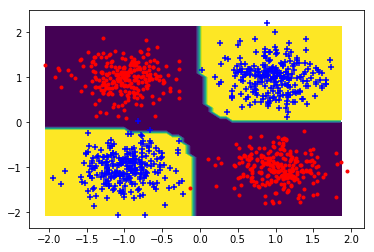

score en train :  0.513
score en test :  0.484


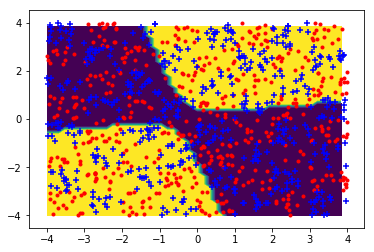

In [12]:
def proj_poly_2D(data):
    #plongement polynomial pour des données 2D
    n=np.shape(data)[0]
    col_id=np.reshape((np.ones(n)),(n,1)) #vecteur colonne de 1
    col_xy=np.reshape(np.multiply(data[:,0],data[:,1]),(n,1))
    col_x2=np.reshape(np.multiply(data[:,0],data[:,0]),(n,1))
    col_y2=np.reshape(np.multiply(data[:,1],data[:,1]),(n,1))
    return np.concatenate((col_id,data,col_xy,col_x2,col_y2),axis=1)  #matrice de design

def question_32(jeu):
    #Test du perceptron sur les autres jeux de données artificielles après plongement polynomial des données
    xtrain,ytrain = gen_arti(data_type=jeu,epsilon=0.01)
    xtest,ytest = gen_arti(data_type=jeu,epsilon=0.01)

    model=learn_and_predict_with_Perceptron(xtrain,ytrain,xtest,ytest,proj=proj_poly_2D)

    plt.figure()
    plot_frontiere(xtest,model.predict,50)
    plot_data(xtest,ytest)
    plt.show()

question_32(1) #jeu de données artificielles #Marche : assez expressif !
question_32(2) #Ne marche pas : pas assez expressif

Question 3.2. (suite)

Plongement polynomial dans le cas 2D [Ce que l'on obtient]

On teste donc le perceptron sur les deux mêmes jeux de données plongées polynomialement et attend toujours 100 itérations pour l'apprentissage.

On observe que le perceptron arrive à bien classifier les données rouges et bleues du premier jeu. On observe que les frontières de décision sont effectivement des hyperboles. La réussite de la classification tient très probablement au coefficient $w_3$ qui correspond au poids de $x_1x_2$ dans la classification ("bleu" quand $x_1x_2$ positif et rouge sinon, soit $w_3$ positif si la classe bleue est la classe "+1"). 

Pour le deuxième jeu, le modèle n'est pas encore assez expressif. Notamment le signe de $x_1x_2$ ne suffit pas à les séparer puisque les points maillent tout l'espace sur un réseau de droites.

Question 3.3.

Plongement gaussien [Ce qui est attendu]

On considère cette fois une fonction de plongement censée être plus riche, allant de  $\mathbb{R}^2$ dans $\mathbb{R}^N_B$ :

$gauss_B(x)=(k(x,\sigma^1),k(x,\sigma^2),...,k(x,\sigma^{N_B}))$  où   $k(x,x')=\exp{-\frac{||x-x'||^2}{2\sigma^2}}$

où les $\sigma^i$ correspondent aux coordonnées de $N_B$ points pris dans l'espace de description des données.

- La i-ème dimension dans l'espace projeté peut donc s'interpréter comme la proximité spatiale d'une donnée au point $\sigma^i$.

- Une valeur importante de la i-ème dimension de $x$ indique la donnée est proche de $\sigma^i$, et l'hypothèse que l'on fait est qu'avec un écart-type $\sigma$ bien choisi, la donnée sera sous l'influence de $\sigma^i$. Au contraire une valeur faible indique que la donnée n'est pas suffisamment proche de $\sigma^i$ pour que son label soit corrélé avec le sien.  $\sigma$ peut donc s'interpréter comme le diamètre du voisinage dans lequel tous les points ont le même label.

- Le poids $w^i$ peut s'interpréter comme l'inclinaison de  $\sigma^i$ à être labellisé +1. Le label est d'autant plus sûrement "+1" (resp. "-1") que $w_i$ est positif (resp. négatif) et élevé. Un poids nul signifie que le label de $\sigma_i$ est incertain, autrement dit que $\sigma^i$ n'apporte rien à la prédiction des labels.

En choisissant les centres des gaussiennes aléatoirement dans l'ensemble de description des données
score en train :  0.809
score en test :  0.626
Nombre de dimensions non nulles (> 10** -5) : 0.731268731269


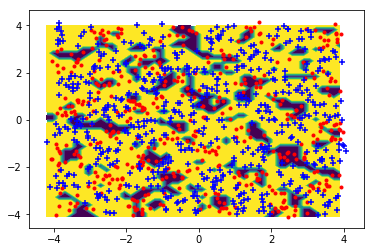

En choisissant les centres des gaussiennes aléatoirement dans l'ensemble des données d'entrainement
score en train :  0.911
score en test :  0.713
Nombre de dimensions non nulles (> 10** -5) : 0.644355644356


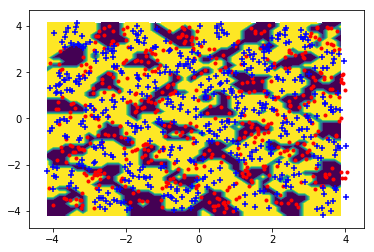

In [41]:
def choose_centers_gaussians(Nb,way,data_train):
    (n,d)=np.shape(data_train)

    #Choix des centres des gaussiennes
    centers=np.zeros((Nb,d)) #Nb points choisis comme centres des gaussiennes
    if way=="alea":
        for dim in range(d):
            min_dim=min(data_train[:,dim]) #minimum des données selon la dimension dim
            max_dim=max(data_train[:,dim])
            centers[:,dim]=((max_dim-min_dim)*np.random.rand(Nb,1)+min_dim).flatten()
    if way=="train":
        idx_centers=(n*np.random.rand(Nb,1)).flatten()
        for i in range(Nb):
            centers[i,:]=data_train[int(idx_centers[i]),:]
    return centers

def proj_gauss(data,pos_centers):
    #plongement gaussien des données, avec Nb gaussiennes descriptives
    #en choisissant centers pour centres des gaussiennes de positions

    Nb=np.shape(pos_centers)[0]
    sigma=0.1#écart-type des gaussiennes

    #Calcul des proximités spatiales à chaque point de la base
    dist_gauss=lambda x:np.array([math.exp(-pow(np.linalg.norm(x-pos_centers[i,:]),2)/(2*pow(sigma,2))) for i in range(Nb)])
    return np.array([dist_gauss(data[i,:]) for i in range(np.shape(data)[0])])

def predicts_with_gaussian_immersion(jeu,nb_gaussians,way,lbd=0):
    #Test du perceptron sur les autres jeux de données artificielles après plongement gaussien des données
    #way = manière de choisir les centres des nb_gaussians gaussiennes
    #si way=alea, on tire aléatoirement des points de l'ensemble de description
    #si way=train, on tire aléatoirement des points de l'ensemble d'entrainement
    #retourne le ratio de dimensions non nulles de w 
    xtrain,ytrain = gen_arti(data_type=jeu,epsilon=0.1)
    xtest,ytest = gen_arti(data_type=jeu,epsilon=0.1)
    model=learn_and_predict_with_Perceptron(xtrain,ytrain,xtest,ytest,proj_gauss,params_gauss=(nb_gaussians,way),lbd=lbd,e=pow(10,-2))

    w = model.histo_w[-1,:]
    print("Nombre de dimensions non nulles (> 10** -5) :",sum(w>10** -5)/(nb_gaussians+1))

    
    plt.figure()
    plot_frontiere(xtest,model.predict,50)
    plot_data(xtest,ytest)
    plt.show()
    
    return sum(w>10** -5)/model.histo_w.shape[0]

def question_33(jeu,nb_gaussians):
    print("En choisissant les centres des gaussiennes aléatoirement dans l'ensemble de description des données")
    predicts_with_gaussian_immersion(jeu,nb_gaussians,"alea") #jeu de données artificielles, nombre de gaussiennes
    print("En choisissant les centres des gaussiennes aléatoirement dans l'ensemble des données d'entrainement")
    predicts_with_gaussian_immersion(jeu,nb_gaussians,"train")

#On peut jouer sur le nombre de gaussiennes et sigma notamment !
#question_33(1,100) #jeu de données artificielles, nombre de gaussiennes. Marche encore !
question_33(2,1000) #Marche fin, le modèle est plus expressif que le précédent !

Question 3.3. (suite)

Plongement gaussien [Ce que l'on obtient]

On expérimente donc le perceptron après plongement gaussien d'un nombre $N_B=100$ (resp. 1000) points pour le jeu de données 1 (resp. pour le jeu de données 2) et pour un écart type $\sigma=0.1$ :
- d'abord en choisissant les $\sigma_i$, centres des gaussiennes, aléatoirement dans l'espace de description
- ensuite en utilisant un sous-échantillon de l'ensemble d'apprentissage

De manière générale, on obtient tout d'abord qu'on obtient avec le plongement gaussien d'encore meilleures performances sur le jeu 1 qu'après plongement polynomial. Sur le jeu 2, le perceptron fait ses premières preuves avec plongement gaussien. A noter qu'avec une recherche très précise de $\sigma$ et $N_B$ optimaux, on doit pouvoir augmenter encore les scores obtenus.

On observe ensuite que les performances sont meilleures si l'on choisit les points $\sigma_i$ de la base de projection dans l'ensemble d'aprentissage que si on les choisit aléatoirement dans l'ensemble de description des données (en effet on connait les labels de l'ensemble d'apprentissage !). Toutefois avec cette méthode, il y a un risque de sur-apprentissage si l'on prend une base de projection de cardinal $N_B$ trop important et un écart-type trop petit. Ce risque est nettement moindre dans le cas où l'on choisit les points de la base aléatoirement dans l'espace, même dans la limite où le nombre de points devient assez important.

Question 3.4.

- Commentaires sur le modèle avec plongement gaussien :

Les meilleures performances obtenues avec le plongement gaussien sont dus à une description plus riche des données du modèle. Dans le modèle linéaire, on décrivait les données par leur abcisse et leur ordonnée. Dans le modèle avec plongement polynomial, on les décrivait notamment aussi par le signe de leur positionnement dans un des quatres cadrans (avec le signe de $x_1x_2$). Dans le modèle avec plongement gaussien, on les caractèrise par leurs proximités à $N_B$ points, 100 ou 1000, dont les labels sont appris au cours de l'apprentissage (les $w_i$).
On comprend mieux ainsi la performance obtenue dans le cas du maillage (jeu 2) avec un plongement gaussien par rapport au plongement polynomial ou linéaire.

- Expressivité du modèle :

Le modèle est d'autant plus expresif que le nombre de dimensions nulles de $w$ est petit. En effet, un poids nul $w_i$ revient à dire que le point $\sigma_i$ n'apporte rien à l'estimation des labels des points autour de lui.

Tracons l'expressivité du modèle, que l'on peut décrire par le ratio de dimensions non nulles de $w$, en fonction du nombre de points choisis pour la base de projection).

score en train :  0.668
score en test :  0.637
score en train :  0.848
score en test :  0.727
score en train :  0.906
score en test :  0.769
score en train :  0.938
score en test :  0.758
score en train :  0.959
score en test :  0.777


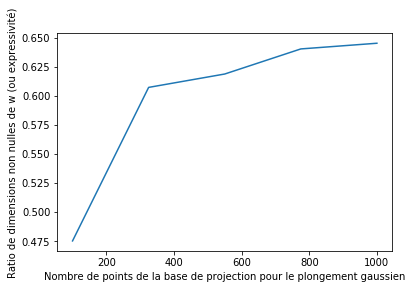

In [51]:
def question_34_1(jeu):
    #Paramètres du plongement gaussien
    way="train"
    
    xtrain,ytrain = gen_arti(data_type=jeu,epsilon=0.01)
    xtest,ytest = gen_arti(data_type=jeu,epsilon=0.01)
   
    res = []
    for nb_gaussians in np.linspace(100,1000,5): 
        model=learn_and_predict_with_Perceptron(xtrain,ytrain,xtest,ytest,proj_gauss,params_gauss=(int(nb_gaussians),way),e=pow(10,-2))

        
        w = model.histo_w[-1,:]
        res += [sum(w>10** -5)/(nb_gaussians+1)]
        
        
    plt.plot(np.linspace(100,1000,5), res)
    plt.xlabel("Nombre de points de la base de projection pour le plongement gaussien")
    plt.ylabel("Ratio de dimensions non nulles de w (ou expressivité)")
    plt.show()

question_34_1(2)

Question 3.4 (suite 1)

Ici, on observe que l'expressivité est maximale, en choisissant tous les points de l'ensemble d'apprentissage pour la base de projection.

- Régularisation :

Le fait qu'on ait utilisé une base de projection de cardinal important (entre 100 et 1000) et un écart-type $\sigma$ relativement faible (0.1) explique la qualité de la classification mais aussi les irrégularités des frontières obtenues, qui peuvent s'interpréter comme du sur-apprentissage (notamment si l'on chosit les points de la base dans l'ensemble d'apprentissage).

Si l'on cherche maintenant à régulariser le problème en ajoutant le terme $\lambda||w||^2$, on obtiendra logiquement des frontières de décisions plus lisse. Mais le risque sera aussi de perdre en expressivité, puisque l'on pénalisera avec la norme euclidiennes des poids $w_i$ trop élevés.

Pour optimiser le choix de $\lambda$ ou la pénalisation des irrégularités, on peut par exemple tracer les courbes d'erreur en apprentissage et en test en fonction de $\lambda$.

score en train :  0.534
score en test :  0.534
score en train :  0.738
score en test :  0.616
score en train :  0.95
score en test :  0.826
score en train :  0.863
score en test :  0.784
score en train :  0.762
score en test :  0.725
score en train :  0.619
score en test :  0.595


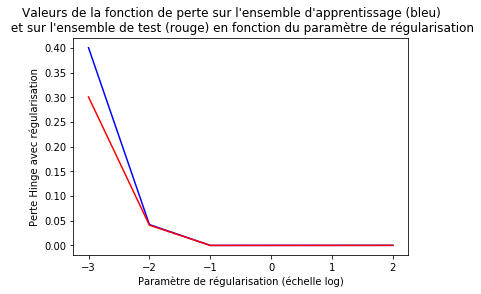

score en train :  0.827
score en test :  0.749
Nombre de dimensions non nulles (> 10** -5) : 0.387612387612


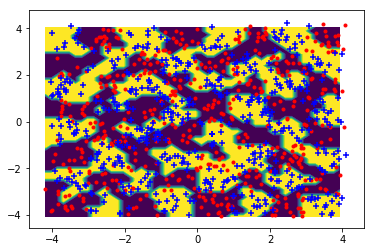

In [52]:
def question_34(jeu,nb_gaussians):
    xtrain,ytrain = gen_arti(data_type=jeu,epsilon=0.01)
    xtest,ytest = gen_arti(data_type=jeu,epsilon=0.01)

    #Paramètres du plongement gaussien
    way="train"
    #1. Optimisation du paramètre de régularisation lbd
    lbd=[pow(10,k) for k in range(-3,3)]
    loss_train=[] #en fonction de lambda
    loss_test=[]
    x = [k for k in range(-3,3)]
    for l in lbd:
        model=learn_and_predict_with_Perceptron(xtrain,ytrain,xtest,ytest,proj_gauss,params_gauss=(nb_gaussians,way),lbd=l,max_iter = 100)
        loss_train.append(model.loss(proj_gauss(xtrain,model.centers_gaussians),ytrain))
        loss_test.append(model.loss(proj_gauss(xtest,model.centers_gaussians),ytest))
    plt.figure()
    plt.plot(x,loss_train,color='b')
    plt.plot(x,loss_test,color='r')
    plt.xlabel("Paramètre de régularisation (échelle log)")
    plt.ylabel("Perte Hinge avec régularisation")
    plt.title("Valeurs de la fonction de perte sur l'ensemble d'apprentissage (bleu) \
    \n et sur l'ensemble de test (rouge) en fonction du paramètre de régularisation")
    plt.show()
    
    #2. Frontière et score pour le meilleur "lambda"
    predicts_with_gaussian_immersion(jeu,nb_gaussians,way,lbd=0.1)

question_34(2,1000) #jeu de données artificielles, nombre de gaussiennes

Question 3.4. (suite 2)

On part donc du modèle avec plongement gaussien et choix des points de la base de projection dans l'ensemble d'apprentissage : c'est en effet un cas à même de faire preuve de sur-apprentissage, et donc où l'on a tout intérêt à régulariser !

On a tracé les erreurs d'apprentissage et de test en fonction de $\lambda$. On observe en effet du sur-apprentissage pour $\lambda$ trop petit. 

Finalement avec $\lambda=0.1$ (et $N_b=1000$ et $\sigma=0.1$) on observe un lissage des frontières en ajoutant le terme de régularisation, et un score en test plus satisfaisant.